Loaded T2_2000-03.nc
Loaded SNOWNC_2000-03.nc
Loaded RAINNC_2000-03.nc
Loaded HAILNC_2000-03.nc
Loaded GRAUPELNC_2000-03.nc


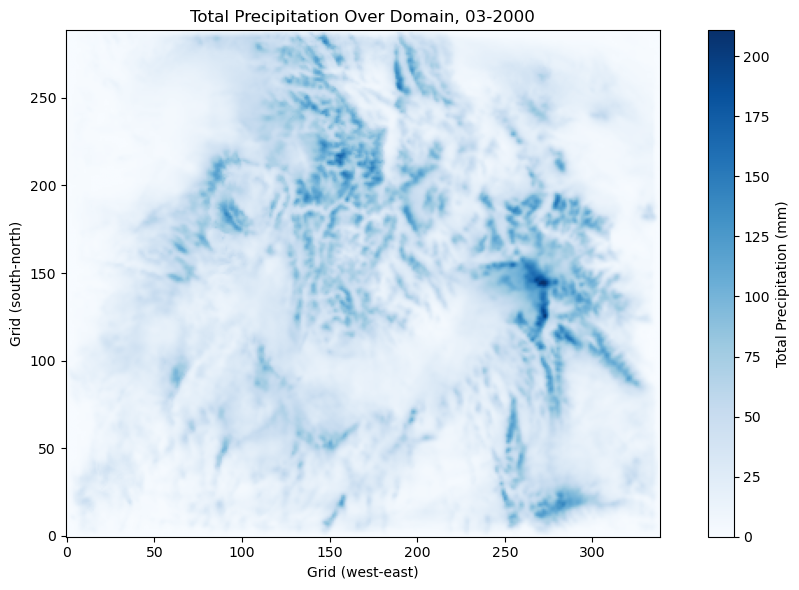

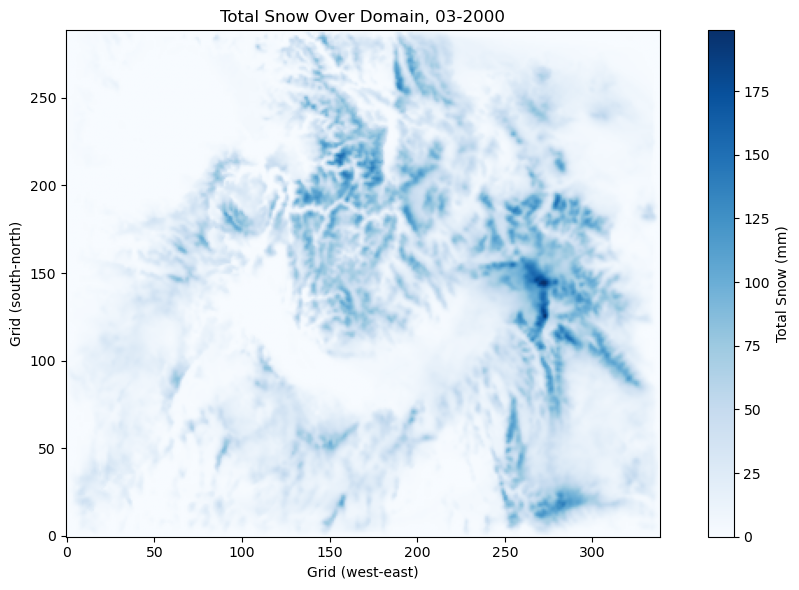

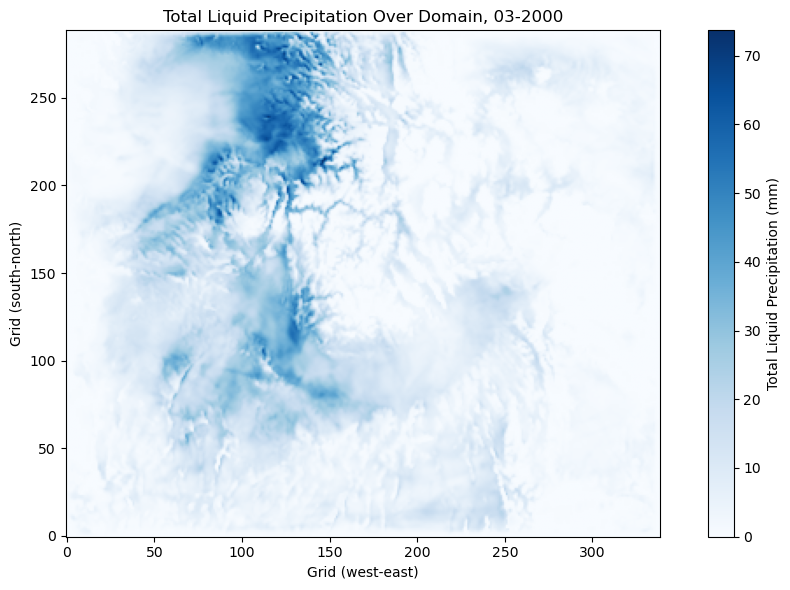

Domain-wide Snow Fraction: 0.613
Snow Fraction Map - Min: 0.0
Snow Fraction Map - Max: 1.0001435
Grid cells with snow fraction > 1: 3
Suspicious cases (snow > precip): 3
Cell (1, 146): Snow = 8.558, Precip = 8.602, Fraction = 0.994874
Cell (1, 147): Snow = 11.984, Precip = 12.057, Fraction = 0.993898
Cell (1, 239): Snow = 8.309, Precip = 8.374, Fraction = 0.992299
Cell (1, 240): Snow = 7.639, Precip = 7.662, Fraction = 0.997036
Cell (1, 255): Snow = 1.877, Precip = 1.877, Fraction = 0.999821
Cell (1, 256): Snow = 2.297, Precip = 2.298, Fraction = 0.999747
Cell (1, 265): Snow = 1.085, Precip = 1.085, Fraction = 0.999883
Cell (1, 266): Snow = 2.003, Precip = 2.003, Fraction = 0.999944
Cell (1, 267): Snow = 3.872, Precip = 3.877, Fraction = 0.998886
Cell (1, 268): Snow = 6.442, Precip = 6.456, Fraction = 0.997783
Cell (1, 269): Snow = 9.049, Precip = 9.081, Fraction = 0.996450
Cell (1, 270): Snow = 10.616, Precip = 10.671, Fraction = 0.994852
Cell (1, 271): Snow = 10.945, Precip = 11.008,

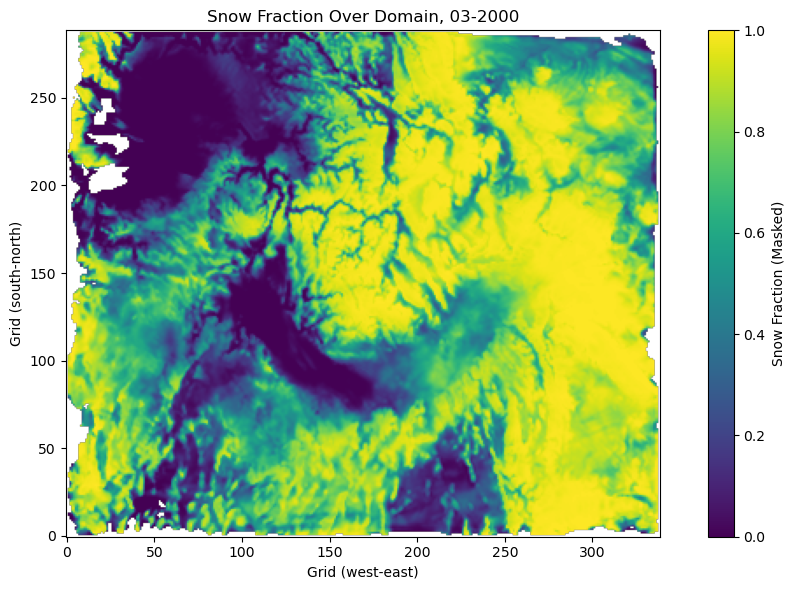

In [7]:
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

# === CONFIGURATION ===
base_dir = "/bsushare/leaf-shared/subset-output-wrf/vol04/wrf_out/wy_2000/d01/"
month = "03"
year = "2000"
target_location = "Domain"
epsilon = 1e-6  # to prevent division by zero

# === FUNCTION TO LOAD A VARIABLE ===
def load_wrf_var(var_name, base_dir, year, month):
    filename = f"{var_name}_{year}-{month}.nc"
    path = os.path.join(base_dir, filename)
    try:
        ds = xr.open_dataset(path)
        print(f"Loaded {filename}")
        return ds
    except FileNotFoundError:
        print(f"File not found: {filename}")
        return None

# === LOAD REQUIRED DATASETS ===
t2 = load_wrf_var("T2", base_dir, year, month)
lats = t2['XLAT'][0, :, :]
lons = t2['XLONG'][0, :, :]
snownc = load_wrf_var("SNOWNC", base_dir, year, month)
rainnc = load_wrf_var("RAINNC", base_dir, year, month)
hailnc = load_wrf_var("HAILNC", base_dir, year, month)
graupelnc = load_wrf_var("GRAUPELNC", base_dir, year, month)

# === CORRECTED RAINNC ACCOUNTING FOR ROLLOVER RESET ===
def fix_accum_reset(rainnc, threshold=100.0):
    diff = rainnc.diff(dim="Time", label="upper")
    corrected_diff = xr.where(diff < 0, diff + threshold, diff)
    corrected_accum = corrected_diff.sum(dim="Time")
    return corrected_accum

# === APPLY TO FULL SPATIAL GRID ===
precipitation_total = fix_accum_reset(rainnc['RAINNC'])

# === EXTRACT AGGREGATE TOTAL FOR TARGET LOCATION ===
temp_series = t2['T2'].mean(dim=["south_north", "west_east"]) - 273.15  # K to °C -- confirm if mean is the correct metric
snow_total = snownc['SNOWNC'].diff(dim="Time").clip(min=0).sum(dim="Time")
hail_total = hailnc['HAILNC'].diff(dim="Time").clip(min=0).sum(dim="Time")
graupel_total = graupelnc['GRAUPELNC'].diff(dim="Time").clip(min=0).sum(dim="Time")
time = t2['XTIME']
time_trimmed = time.isel(Time=slice(1, None))
liquid_total = precipitation_total - snow_total - hail_total - graupel_total

# === CALCULATE FRACTIONS WITH MASKING ===
valid_mask = precipitation_total >= 1.0

# Mask snow and precip where total precip is too low
masked_snow_total = snow_total.where(valid_mask)
masked_precip_total = precipitation_total.where(valid_mask)
masked_liquid_total = liquid_total.where(valid_mask)

# Compute fractions only where valid
total_snow = masked_snow_total.sum(dim=["south_north", "west_east"])
total_precip = masked_precip_total.sum(dim=["south_north", "west_east"])
snow_fraction = total_snow / (total_precip + epsilon)
liquid_fraction = masked_liquid_total / (masked_precip_total + epsilon)

# === PLOT TOTAL PRECIPITATION ===
plt.figure(figsize=(10, 6))
precip_total_map = precipitation_total
im = plt.imshow(precipitation_total, cmap="Blues", origin="lower")
plt.colorbar(im,label="Total Precipitation (mm)")
plt.title(f"Total Precipitation Over {target_location}, {month}-{year}")
plt.xlabel("Grid (west-east)")
plt.ylabel("Grid (south-north)")
plt.tight_layout()
plt.show()

# === PLOT TOTAL SNOW ===
plt.figure(figsize=(10, 6))
snow_total_map = snow_total
im = plt.imshow(snow_total, cmap="Blues", origin="lower")
plt.colorbar(im,label="Total Snow (mm)")
plt.title(f"Total Snow Over {target_location}, {month}-{year}")
plt.xlabel("Grid (west-east)")
plt.ylabel("Grid (south-north)")
plt.tight_layout()
plt.show()

# === PLOT TOTAL LIQUID ===
plt.figure(figsize=(10, 6))
liquid_total_map = liquid_total
im = plt.imshow(liquid_total, cmap="Blues", origin="lower")
plt.colorbar(im,label="Total Liquid Precipitation (mm)")
plt.title(f"Total Liquid Precipitation Over {target_location}, {month}-{year}")
plt.xlabel("Grid (west-east)")
plt.ylabel("Grid (south-north)")
plt.tight_layout()
plt.show()

# === PLOT TOTAL SNOW FRACTION ===
snow_fraction_map = snow_total / (precipitation_total + epsilon)
masked_snow_fraction = snow_fraction_map.where(valid_mask)
domain_avg_snow_fraction = masked_snow_fraction.mean().values
print(f"Domain-wide Snow Fraction: {domain_avg_snow_fraction:.3f}")
print("Snow Fraction Map - Min:", masked_snow_fraction.min().values)
print("Snow Fraction Map - Max:", masked_snow_fraction.max().values)
exceeds_one = masked_snow_fraction > 1.0
count_exceeds = exceeds_one.sum().item()
max_val = masked_snow_fraction.max().item()
print(f"Grid cells with snow fraction > 1: {count_exceeds}")
suspicious = (snow_total > precipitation_total) & valid_mask
print(f"Suspicious cases (snow > precip): {suspicious.sum().item()}")

threshold = 1.0 + 1e-3  # slightly over 1
near_one_mask = (masked_snow_fraction > 0.99) & (masked_snow_fraction <= threshold)
coords = np.argwhere(near_one_mask.values)
for i, j in coords:
    snow_val = snow_total.values[i, j]
    precip_val = precipitation_total.values[i, j]
    fraction_val = snow_val / (precip_val + epsilon)
    print(f"Cell ({i}, {j}): Snow = {snow_val:.3f}, Precip = {precip_val:.3f}, Fraction = {fraction_val:.6f}")


plt.figure(figsize=(10, 6))
im = plt.imshow(masked_snow_fraction, cmap="viridis", origin="lower", vmin=0, vmax=1)
plt.colorbar(im, label="Snow Fraction (Masked)")
plt.title(f"Snow Fraction Over {target_location}, {month}-{year}")
plt.xlabel("Grid (west-east)")
plt.ylabel("Grid (south-north)")
plt.tight_layout()
plt.show()